# SVR 模型训练

使用标准化后的数据训练 SVR (支持向量回归) 模型，预测 lipid(%) 含量。

## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## 2. 加载数据

In [2]:
# 数据路径
TRAIN_PATH = 'data/augmentdata/train_normalized.csv'
TEST_PATH = 'data/augmentdata/test_normalized.csv'

# 特征列和目标列
FEATURE_COLS = ['pH', 'DO', 'COD', 'BOD', 'Total photosynthetic pigments', 
                'Dry cell weight', 'protein(%)', 'H(%)', 'O(%)']
TARGET_COL = 'lipid(%)'

# 加载数据
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# 准备特征和目标
X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]
X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]

# SVR 对特征缩放敏感，需要标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'训练集: {X_train.shape[0]} 样本, {X_train.shape[1]} 特征')
print(f'测试集: {X_test.shape[0]} 样本, {X_test.shape[1]} 特征')

训练集: 140 样本, 9 特征
测试集: 8 样本, 9 特征


## 3. 网格搜索超参数调优

基于测试集 R² 寻找最佳参数组合。

In [3]:
# 使用 GridSearchCV 进行 5 折交叉验证超参数调优
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# 基础模型
base_model = SVR()

# GridSearchCV: 在训练集内部进行 5 折交叉验证
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# 在训练集上进行交叉验证调参
grid_search.fit(X_train_scaled, y_train)

# 最佳模型和参数
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_r2 = grid_search.best_score_

print(f'\n5 折交叉验证最佳 R²: {best_cv_r2:.4f}')
print('\n最佳参数:')
for param, value in best_params.items():
    print(f'  {param}: {value}')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

5 折交叉验证最佳 R²: 0.9320

最佳参数:
  C: 1
  epsilon: 0.5
  gamma: 1
  kernel: poly


## 4. 模型评估

In [4]:
# 使用交叉验证预测结果评估训练集性能
y_train_cv_pred = cross_val_predict(best_model, X_train_scaled, y_train, cv=5)
y_test_pred = best_model.predict(X_test_scaled)

# 计算评估指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_cv_pred))
train_mae = mean_absolute_error(y_train, y_train_cv_pred)
train_r2 = r2_score(y_train, y_train_cv_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('模型评估结果\n')
print('训练集 (5 折交叉验证):')
print(f'  RMSE: {train_rmse:.4f}')
print(f'  MAE:  {train_mae:.4f}')
print(f'  R²:   {train_r2:.4f}')
print()
print('测试集:')
print(f'  RMSE: {test_rmse:.4f}')
print(f'  MAE:  {test_mae:.4f}')
print(f'  R²:   {test_r2:.4f}')

模型评估结果

训练集 (5 折交叉验证):
  RMSE: 1.2469
  MAE:  0.8644
  R²:   0.9390

测试集:
  RMSE: 45.8083
  MAE:  26.9968
  R²:   -107.9266


## 5. 支持向量分析

In [5]:
# 获取支持向量信息
n_support = best_model.n_support_
support_vectors = best_model.support_vectors_

print(f'支持向量数量: {len(best_model.support_)}')
print(f'支持向量占训练样本比例: {len(best_model.support_) / len(X_train) * 100:.2f}%')
print(f'\n支持向量索引 (前20个): {best_model.support_[:20]}')

支持向量数量: 76
支持向量占训练样本比例: 54.29%

支持向量索引 (前20个): [ 0  3  7  8 10 13 15 16 17 19 21 22 25 26 27 28 29 30 31 36]


## 6. 预测结果可视化

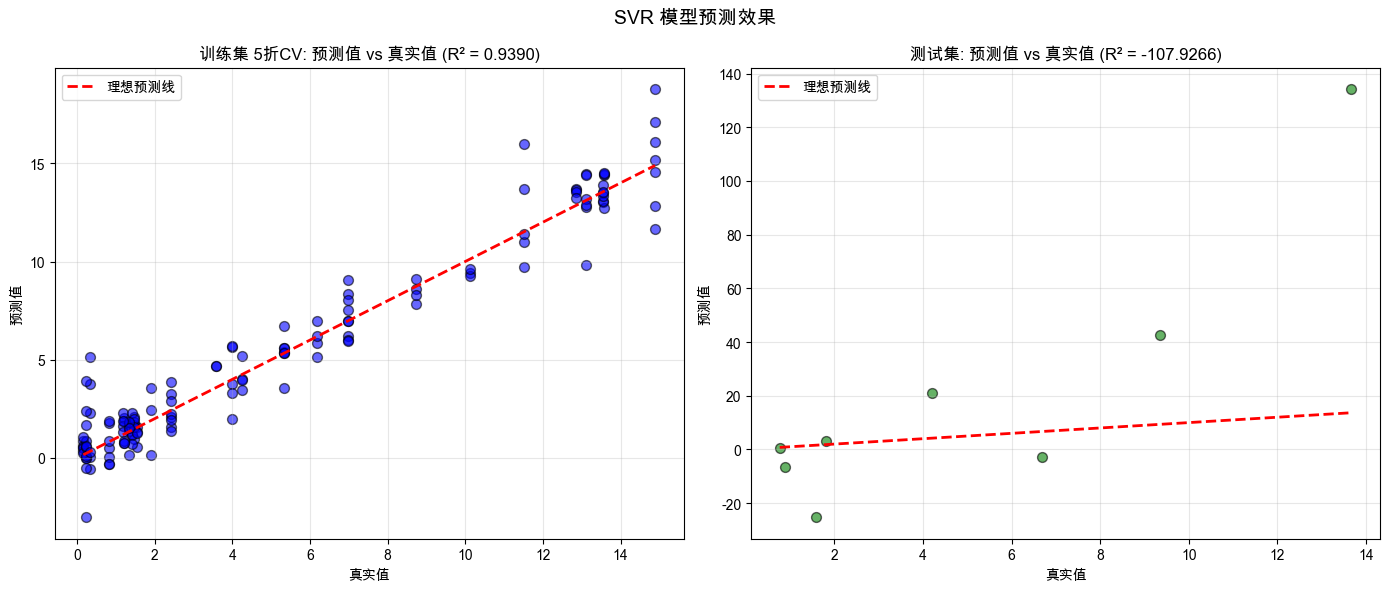

In [6]:
# 预测值 vs 真实值散点图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 训练集
ax1 = axes[0]
ax1.scatter(y_train, y_train_cv_pred, alpha=0.6, color='blue', edgecolors='k', s=50)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='理想预测线')
ax1.set_xlabel('真实值')
ax1.set_ylabel('预测值')
ax1.set_title(f'训练集 5折CV: 预测值 vs 真实值 (R² = {train_r2:.4f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 测试集
ax2 = axes[1]
ax2.scatter(y_test, y_test_pred, alpha=0.6, color='green', edgecolors='k', s=50)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='理想预测线')
ax2.set_xlabel('真实值')
ax2.set_ylabel('预测值')
ax2.set_title(f'测试集: 预测值 vs 真实值 (R² = {test_r2:.4f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('SVR 模型预测效果', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. 测试集预测详情

In [7]:
# 显示测试集的预测详情
test_results = pd.DataFrame({
    '真实值': y_test.values,
    '预测值': y_test_pred,
    '误差': y_test.values - y_test_pred,
    '绝对误差': np.abs(y_test.values - y_test_pred)
})

print('测试集预测详情:\n')
test_results

测试集预测详情:



,真实值,预测值,误差,绝对误差
0,6.690000,-2.790098,9.480098,9.480098
1,9.347000,42.675007,-33.328007,33.328007
2,0.766912,0.518326,0.248586,0.248586
3,0.881452,-6.655483,7.536935,7.536935
4,1.587000,-25.278472,26.865472,26.865472
5,4.208457,20.887311,-16.678855,16.678855
6,1.822245,3.126027,-1.303782,1.303782
7,13.674000,134.206398,-120.532398,120.532398
